In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import sklearn

In [2]:
from pymongo import MongoClient
client = MongoClient('mongodb://localhost:27017/')
client.list_database_names()
db = client["LP-database"]
LP_predict_collection = db["lp_prediction"]
LP_predict_collection.remove({})

/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: remove is deprecated. Use delete_one or delete_many instead.
  


{'n': 70, 'ok': 1.0}

In [3]:
contracts  = 10000.0
count=1
def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts
    else:
        return -abs(row['return'])*contracts

def predictBestLP(df, lpid):
    global count
    df['return'] = df['Ohlc'] - df['Ohlc'].shift(1)
    return_range = df['return'].max() - df['return'].min()
    df['return'] = df['return'] / return_range
    df['label'] = df['return'].shift(-1)
    df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
    df['return'].fillna((df['return'].mean()), inplace = True) 
    n_features = 60 # number of features
    train_x = np.array([]).reshape([-1,n_features])
    train_y = np.array([]).reshape([-1,1])
    for index, row in df.iterrows():
        i = df.index.get_loc(index)
        if i<n_features:
            continue
    
        _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
        _y = df.iloc[i]['label']
        train_x = np.vstack((train_x, _x))
        train_y = np.vstack((train_y, _y))
    train_y = train_y.reshape([-1])
    print(train_x.shape)
    print(train_y.shape)
    print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
    print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))
    from sklearn.neighbors import KNeighborsClassifier 
    knn = KNeighborsClassifier(n_neighbors=3) 
    knn.fit(train_x,train_y) 
    train_len = int(len(train_x)*0.80)
    accuracy = knn.score(train_x[train_len:], train_y[train_len:])
    print('Training Accuracy: %f' % accuracy)
    test_len = int(len(train_x)*0.20)
    accuracy = knn.score(train_x[:test_len], train_y[:test_len])
    print('Testing Accuracy: %f' % accuracy)
    pred = knn.predict(train_x[train_len:])
    df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
    df_trade['label']  = train_y[train_len:]
    df_trade['pred']   = pred
    df_trade['won']    = df_trade['label'] == df_trade['pred']
    df_trade['return'] = df_trade['return'].shift(-1) * return_range
    df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)
    df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
    df_trade['equity'] = df_trade['pnl'].cumsum()

    display(df_trade.tail())
    df_trade.plot(y='equity', figsize=(10,4), title='Backtest with $10000 initial capital')
    plt.xlabel('Trades')
    plt.ylabel('Equity (USD)')
    for r in df_trade.iterrows():
        if r[1]['won']:
            plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
        else:
            plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')
    n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
    n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
    print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
    netProfit=int(df_trade.tail(1)['equity'])
    print("Number Winning Trades : %d" % n_win_trades)
    print("Number Losing Trades  : %d" % n_los_trades)
    print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
    print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
    print("Avg Loss Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
    print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
    print("Largest Loss Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
    print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))
    LP_predict_collection.insert_one({"currencyPair":df['currencyPair'].iloc[0],"LP_id":lpid,"PercentProfitable":(100*n_win_trades/(n_win_trades + n_los_trades)),"ProfitFactor":abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()),"NetProfit":netProfit})
    df_trade['pnl'].hist(bins=20)
    count=count+1

In [4]:

def performPred(df):
    LP1=df.loc[df['LP_id'] == 1]  
    LP2=df.loc[df['LP_id'] == 2]
    LP3=df.loc[df['LP_id'] == 3]  
    LP4=df.loc[df['LP_id'] == 4]
    LP5=df.loc[df['LP_id'] == 5]  
    LP6=df.loc[df['LP_id'] == 6]
    LP7=df.loc[df['LP_id'] == 7]
    predictBestLP(LP1, 1)
    predictBestLP(LP2, 2)
    predictBestLP(LP3, 3)
    predictBestLP(LP4, 4)
    predictBestLP(LP5, 5)
    predictBestLP(LP6, 6)
    predictBestLP(LP7, 7)
    
    recommendation = db["lp_pred_count"]
    x=LP_predict_collection.find_one({'currencyPair':df['currencyPair'].iloc[0]},sort=[("ProfitFactor", -1)])['LP_id']
    counter=recommendation.find_one({"currencyPair":df['currencyPair'].iloc[0],"LPid":x})['count']
    myquery= { "LPid": x,'currencyPair':df['currencyPair'].iloc[0] }
    newvalues = { "$set": { "count": counter+1 } }
    recommendation.update_one(myquery, newvalues)

In [5]:
collection = db["cp1"]
pipeline = [
    {"$unwind":{'path': '$LP', 'preserveNullAndEmptyArrays': True}},
    {"$unwind":{'path': '$LP.details', 'preserveNullAndEmptyArrays': True}},
    {'$project':{
      'id':'$id','LP_id':"$LP.id",'currencyPair':'$currencyPair','timestamp':"$LP.details.timestamp",'open':"$LP.details.open",'close':"$LP.details.close",'high':"$LP.details.high",
        'low':"$LP.details.low"
    }}
]

df = pd.DataFrame() 

query_result = collection.aggregate(pipeline)
query_result = list(query_result)
df = pd.io.json.json_normalize(query_result)
df.drop('_id', axis=1, inplace=True)


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61080 entries, 0 to 61079
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LP_id         61080 non-null  int64  
 1   currencyPair  61080 non-null  object 
 2   timestamp     61080 non-null  float64
 3   open          61080 non-null  float64
 4   close         61080 non-null  float64
 5   high          61080 non-null  float64
 6   low           61080 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 3.3+ MB


In [7]:
df = df.dropna(axis = 0, how ='any') 

In [8]:
df['Ohlc'] =(df['low'] + df['high'] + df['open'] + df['close'])/4

/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(912, 60)
(912,)
% of Class0 : 0.517544
% of Class1 : 0.482456
Training Accuracy: 0.775956
Testing Accuracy: 0.769231


,return,label,pred,won,pnl,equity
177,0.000133,1.0,0.0,False,-1.325,508.450
178,0.000347,1.0,1.0,True,3.475,511.925
179,-0.001492,0.0,1.0,False,-14.925,497.000
180,0.000290,1.0,1.0,True,2.900,499.900
181,0.843180,1.0,1.0,True,8431.800,8931.700


Net Profit            : $8931.70
Number Winning Trades : 141
Number Losing Trades  : 41
Percent Profitable    : 77.47%
Avg Win Trade         : $64.524
Avg Loss Trade         : $-4.054
Largest Win Trade     : $8431.800
Largest Loss Trade     : $-17.350
Profit Factor         : 54.74


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.519210
% of Class1 : 0.480790
Training Accuracy: 0.775956
Testing Accuracy: 0.730769


,return,label,pred,won,pnl,equity
177,-0.000660,0.0,0.0,True,6.600,542.925
178,0.000105,1.0,1.0,True,1.050,543.975
179,0.000352,1.0,1.0,True,3.525,547.500
180,-0.001447,0.0,1.0,False,-14.475,533.025
181,0.000293,1.0,1.0,True,2.925,535.950


Net Profit            : $535.95
Number Winning Trades : 142
Number Losing Trades  : 40
Percent Profitable    : 78.02%
Avg Win Trade         : $4.718
Avg Loss Trade         : $-3.351
Largest Win Trade     : $30.325
Largest Loss Trade     : $-14.475
Profit Factor         : 5.00


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.517014
% of Class1 : 0.482986
Training Accuracy: 0.770492
Testing Accuracy: 0.736264


,return,label,pred,won,pnl,equity
177,-0.000657,0.0,0.0,True,6.5750,493.8500
178,0.000120,1.0,1.0,True,1.2000,495.0500
179,0.000355,1.0,1.0,True,3.5500,498.6000
180,-0.001479,0.0,0.0,True,14.7875,513.3875
181,0.000289,1.0,0.0,False,-2.8875,510.5000


Net Profit            : $510.50
Number Winning Trades : 140
Number Losing Trades  : 42
Percent Profitable    : 76.92%
Avg Win Trade         : $4.678
Avg Loss Trade         : $-3.439
Largest Win Trade     : $30.025
Largest Loss Trade     : $-13.875
Profit Factor         : 4.53


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(908, 60)
(908,)
% of Class0 : 0.525330
% of Class1 : 0.474670
Training Accuracy: 0.719780
Testing Accuracy: 0.729282


,return,label,pred,won,pnl,equity
176,-0.000548,0.0,0.0,True,5.475,455.625
177,-0.000672,0.0,1.0,False,-6.725,448.900
178,0.000120,1.0,0.0,False,-1.200,447.700
179,0.000367,1.0,1.0,True,3.675,451.375
180,-0.001185,0.0,1.0,False,-11.850,439.525


Net Profit            : $439.52
Number Winning Trades : 130
Number Losing Trades  : 51
Percent Profitable    : 71.82%
Avg Win Trade         : $4.838
Avg Loss Trade         : $-3.714
Largest Win Trade     : $29.875
Largest Loss Trade     : $-17.325
Profit Factor         : 3.32


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(912, 60)
(912,)
% of Class0 : 0.519737
% of Class1 : 0.480263
Training Accuracy: 0.786885
Testing Accuracy: 0.719780


,return,label,pred,won,pnl,equity
177,0.000115,1.0,0.0,False,-1.1500,471.9000
178,0.000360,1.0,1.0,True,3.6000,475.5000
179,-0.001479,0.0,0.0,True,14.7875,490.2875
180,0.725005,1.0,1.0,True,7250.0500,7740.3375
181,-0.724709,0.0,0.0,True,7247.0875,14987.4250


Net Profit            : $14987.43
Number Winning Trades : 143
Number Losing Trades  : 39
Percent Profitable    : 78.57%
Avg Win Trade         : $105.904
Avg Loss Trade         : $-4.023
Largest Win Trade     : $7250.050
Largest Loss Trade     : $-15.600
Profit Factor         : 96.52
(144, 60)
(144,)
% of Class0 : 0.506944
% of Class1 : 0.493056
Training Accuracy: 0.689655
Testing Accuracy: 0.785714


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,-0.000270,0.0,0.0,True,2.700,48.450
24,0.000233,1.0,0.0,False,-2.325,46.125
25,-0.000555,0.0,1.0,False,-5.550,40.575
26,0.000000,0.0,0.0,True,0.000,40.575
27,0.000000,0.0,0.0,True,0.000,40.575


Net Profit            : $40.57
Number Winning Trades : 17
Number Losing Trades  : 9
Percent Profitable    : 65.38%
Avg Win Trade         : $3.912
Avg Loss Trade         : $-2.881
Largest Win Trade     : $10.250
Largest Loss Trade     : $-5.550
Profit Factor         : 2.57


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(1188, 60)
(1188,)
% of Class0 : 0.545455
% of Class1 : 0.454545
Training Accuracy: 0.806723
Testing Accuracy: 0.729958


,return,label,pred,won,pnl,equity
232,-0.000100,0.0,0.0,True,1.00,448.50
233,0.000100,1.0,1.0,True,1.00,449.50
234,0.012975,1.0,0.0,False,-129.75,319.75
235,0.002025,1.0,1.0,True,20.25,340.00
236,0.000000,0.0,1.0,False,-0.00,340.00


Net Profit            : $340.00
Number Winning Trades : 172
Number Losing Trades  : 42
Percent Profitable    : 80.37%
Avg Win Trade         : $3.551
Avg Loss Trade         : $-6.446
Largest Win Trade     : $20.250
Largest Loss Trade     : $-129.750
Profit Factor         : 2.26


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.523600
% of Class1 : 0.476400
Training Accuracy: 0.770492
Testing Accuracy: 0.736264


,return,label,pred,won,pnl,equity
177,-0.14600,0.0,0.0,True,1460.0,66405.0
178,-0.06925,0.0,0.0,True,692.5,67097.5
179,0.07300,1.0,0.0,False,-730.0,66367.5
180,0.47900,1.0,1.0,True,4790.0,71157.5
181,0.00550,1.0,1.0,True,55.0,71212.5


Net Profit            : $71212.50
Number Winning Trades : 140
Number Losing Trades  : 42
Percent Profitable    : 76.92%
Avg Win Trade         : $598.839
Avg Loss Trade         : $-300.595
Largest Win Trade     : $6312.500
Largest Loss Trade     : $-1387.500
Profit Factor         : 6.64


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.522503
% of Class1 : 0.477497
Training Accuracy: 0.797814
Testing Accuracy: 0.708791


,return,label,pred,won,pnl,equity
177,-0.14675,0.0,0.0,True,1467.5,69887.5
178,-0.06900,0.0,0.0,True,690.0,70577.5
179,0.07275,1.0,0.0,False,-727.5,69850.0
180,0.48175,1.0,1.0,True,4817.5,74667.5
181,0.00525,1.0,1.0,True,52.5,74720.0


Net Profit            : $74720.00
Number Winning Trades : 144
Number Losing Trades  : 37
Percent Profitable    : 79.56%
Avg Win Trade         : $594.722
Avg Loss Trade         : $-295.135
Largest Win Trade     : $6315.000
Largest Loss Trade     : $-1377.500
Profit Factor         : 7.84


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.523600
% of Class1 : 0.476400
Training Accuracy: 0.803279
Testing Accuracy: 0.725275


,return,label,pred,won,pnl,equity
177,-0.146000,0.0,0.0,True,1460.00,74920.00
178,-0.068750,0.0,0.0,True,687.50,75607.50
179,0.073000,1.0,0.0,False,-730.00,74877.50
180,0.479750,1.0,1.0,True,4797.50,79675.00
181,0.005375,1.0,1.0,True,53.75,79728.75


Net Profit            : $79728.75
Number Winning Trades : 146
Number Losing Trades  : 36
Percent Profitable    : 80.22%
Avg Win Trade         : $603.142
Avg Loss Trade         : $-231.389
Largest Win Trade     : $6317.500
Largest Loss Trade     : $-780.000
Profit Factor         : 10.57


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(909, 60)
(909,)
% of Class0 : 0.523652
% of Class1 : 0.476348
Training Accuracy: 0.791209
Testing Accuracy: 0.707182


,return,label,pred,won,pnl,equity
176,-0.14675,0.0,0.0,True,1467.5,70910.0
177,-0.06950,0.0,0.0,True,695.0,71605.0
178,0.07350,1.0,0.0,False,-735.0,70870.0
179,0.48075,1.0,1.0,True,4807.5,75677.5
180,0.00525,1.0,1.0,True,52.5,75730.0


Net Profit            : $75730.00
Number Winning Trades : 143
Number Losing Trades  : 38
Percent Profitable    : 79.01%
Avg Win Trade         : $601.014
Avg Loss Trade         : $-268.816
Largest Win Trade     : $6307.500
Largest Loss Trade     : $-795.000
Profit Factor         : 8.41


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.527473
% of Class1 : 0.472527
Training Accuracy: 0.813187
Testing Accuracy: 0.736264


,return,label,pred,won,pnl,equity
176,-0.02275,0.0,0.0,True,227.5,71340.0
177,-0.14700,0.0,0.0,True,1470.0,72810.0
178,-0.07000,0.0,0.0,True,700.0,73510.0
179,0.07300,1.0,0.0,False,-730.0,72780.0
180,0.48625,1.0,1.0,True,4862.5,77642.5


Net Profit            : $77642.50
Number Winning Trades : 147
Number Losing Trades  : 34
Percent Profitable    : 81.22%
Avg Win Trade         : $592.721
Avg Loss Trade         : $-279.044
Largest Win Trade     : $6322.500
Largest Loss Trade     : $-800.000
Profit Factor         : 9.18
(143, 60)
(143,)
% of Class0 : 0.580420
% of Class1 : 0.419580
Training Accuracy: 0.793103
Testing Accuracy: 0.642857


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,-0.00275,0.0,0.0,True,27.5,2322.5
24,0.00600,1.0,1.0,True,60.0,2382.5
25,0.52325,1.0,1.0,True,5232.5,7615.0
26,-0.01700,0.0,0.0,True,170.0,7785.0
27,0.00000,0.0,0.0,True,0.0,7785.0


Net Profit            : $7785.00
Number Winning Trades : 21
Number Losing Trades  : 6
Percent Profitable    : 77.78%
Avg Win Trade         : $445.238
Avg Loss Trade         : $-260.833
Largest Win Trade     : $5232.500
Largest Loss Trade     : $-542.500
Profit Factor         : 5.97


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(972, 60)
(972,)
% of Class0 : 0.523663
% of Class1 : 0.476337
Training Accuracy: 0.789744
Testing Accuracy: 0.742268


,return,label,pred,won,pnl,equity
189,0.000375,1.0,1.0,True,3.75,51871.25
190,0.004625,1.0,1.0,True,46.25,51917.50
191,1.052500,1.0,0.0,False,-10525.00,41392.50
192,0.110000,1.0,1.0,True,1100.00,42492.50
193,0.000000,0.0,0.0,True,0.00,42492.50


Net Profit            : $42492.50
Number Winning Trades : 152
Number Losing Trades  : 41
Percent Profitable    : 78.76%
Avg Win Trade         : $416.201
Avg Loss Trade         : $-506.585
Largest Win Trade     : $2638.750
Largest Loss Trade     : $-10525.000
Profit Factor         : 3.05


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.510428
% of Class1 : 0.489572
Training Accuracy: 0.765027
Testing Accuracy: 0.736264


,return,label,pred,won,pnl,equity
177,-0.001035,0.0,0.0,True,10.350,488.400
178,-0.000722,0.0,0.0,True,7.225,495.625
179,-0.000033,0.0,0.0,True,0.325,495.950
180,-0.001098,0.0,0.0,True,10.975,506.925
181,-0.000087,0.0,0.0,True,0.875,507.800


Net Profit            : $507.80
Number Winning Trades : 139
Number Losing Trades  : 43
Percent Profitable    : 76.37%
Avg Win Trade         : $4.648
Avg Loss Trade         : $-3.217
Largest Win Trade     : $29.950
Largest Loss Trade     : $-9.450
Profit Factor         : 4.67


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.513721
% of Class1 : 0.486279
Training Accuracy: 0.775956
Testing Accuracy: 0.747253


,return,label,pred,won,pnl,equity
177,-0.001047,0.0,0.0,True,10.4750,451.5250
178,-0.000695,0.0,0.0,True,6.9500,458.4750
179,-0.000063,0.0,0.0,True,0.6250,459.1000
180,-0.001051,0.0,0.0,True,10.5125,469.6125
181,-0.000085,0.0,0.0,True,0.8500,470.4625


Net Profit            : $470.46
Number Winning Trades : 141
Number Losing Trades  : 41
Percent Profitable    : 77.47%
Avg Win Trade         : $4.412
Avg Loss Trade         : $-3.697
Largest Win Trade     : $26.725
Largest Loss Trade     : $-29.825
Profit Factor         : 4.10


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.513721
% of Class1 : 0.486279
Training Accuracy: 0.754098
Testing Accuracy: 0.763736


,return,label,pred,won,pnl,equity
177,-0.001032,0.0,0.0,True,10.3250,412.2000
178,-0.000705,0.0,0.0,True,7.0500,419.2500
179,-0.000058,0.0,0.0,True,0.5750,419.8250
180,-0.001084,0.0,0.0,True,10.8375,430.6625
181,-0.000089,0.0,0.0,True,0.8875,431.5500


Net Profit            : $431.55
Number Winning Trades : 137
Number Losing Trades  : 44
Percent Profitable    : 75.69%
Avg Win Trade         : $4.421
Avg Loss Trade         : $-3.958
Largest Win Trade     : $26.675
Largest Loss Trade     : $-29.725
Profit Factor         : 3.48


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(909, 60)
(909,)
% of Class0 : 0.518152
% of Class1 : 0.481848
Training Accuracy: 0.741758
Testing Accuracy: 0.729282


,return,label,pred,won,pnl,equity
176,-0.001027,0.0,0.0,True,10.275,423.575
177,-0.000705,0.0,0.0,True,7.050,430.625
178,-0.000063,0.0,0.0,True,0.625,431.250
179,-0.001097,0.0,0.0,True,10.975,442.225
180,-0.000083,0.0,0.0,True,0.825,443.050


Net Profit            : $443.05
Number Winning Trades : 134
Number Losing Trades  : 46
Percent Profitable    : 74.44%
Avg Win Trade         : $4.603
Avg Loss Trade         : $-3.778
Largest Win Trade     : $29.600
Largest Loss Trade     : $-16.350
Profit Factor         : 3.55


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.522503
% of Class1 : 0.477497
Training Accuracy: 0.759563
Testing Accuracy: 0.703297


,return,label,pred,won,pnl,equity
177,-0.001040,0.0,0.0,True,10.4000,467.1000
178,-0.000705,0.0,0.0,True,7.0500,474.1500
179,-0.000055,0.0,0.0,True,0.5500,474.7000
180,-0.001059,0.0,0.0,True,10.5875,485.2875
181,-0.000096,0.0,0.0,True,0.9625,486.2500


Net Profit            : $486.25
Number Winning Trades : 137
Number Losing Trades  : 43
Percent Profitable    : 76.11%
Avg Win Trade         : $4.559
Avg Loss Trade         : $-3.216
Largest Win Trade     : $29.900
Largest Loss Trade     : $-9.025
Profit Factor         : 4.52
(143, 60)
(143,)
% of Class0 : 0.552448
% of Class1 : 0.447552
Training Accuracy: 0.758621
Testing Accuracy: 0.678571


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,0.000430,1.0,1.0,True,4.300,72.625
24,-0.000320,0.0,0.0,True,3.200,75.825
25,-0.001308,0.0,0.0,True,13.075,88.900
26,0.000328,1.0,0.0,False,-3.275,85.625
27,0.000000,0.0,0.0,True,0.000,85.625


Net Profit            : $85.63
Number Winning Trades : 21
Number Losing Trades  : 6
Percent Profitable    : 77.78%
Avg Win Trade         : $4.636
Avg Loss Trade         : $-1.954
Largest Win Trade     : $13.075
Largest Loss Trade     : $-4.200
Profit Factor         : 8.30


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(972, 60)
(972,)
% of Class0 : 0.528807
% of Class1 : 0.471193
Training Accuracy: 0.758974
Testing Accuracy: 0.706186


,return,label,pred,won,pnl,equity
189,-0.000150,0.0,0.0,True,1.50,398.25
190,-0.000175,0.0,0.0,True,1.75,400.00
191,-0.004550,0.0,0.0,True,45.50,445.50
192,0.000500,1.0,1.0,True,5.00,450.50
193,0.000000,0.0,0.0,True,0.00,450.50


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $450.50
Number Winning Trades : 144
Number Losing Trades  : 46
Percent Profitable    : 75.79%
Avg Win Trade         : $4.061
Avg Loss Trade         : $-2.918
Largest Win Trade     : $45.500
Largest Loss Trade     : $-8.500
Profit Factor         : 4.36


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.473106
% of Class1 : 0.526894
Training Accuracy: 0.814208
Testing Accuracy: 0.763736


,return,label,pred,won,pnl,equity
177,0.000725,1.0,1.0,True,7.250,599.125
178,0.000035,1.0,1.0,True,0.350,599.475
179,-0.000203,0.0,1.0,False,-2.025,597.450
180,0.002968,1.0,1.0,True,29.675,627.125
181,0.000035,1.0,1.0,True,0.350,627.475


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $627.47
Number Winning Trades : 149
Number Losing Trades  : 32
Percent Profitable    : 82.32%
Avg Win Trade         : $4.858
Avg Loss Trade         : $-3.011
Largest Win Trade     : $40.475
Largest Loss Trade     : $-18.175
Profit Factor         : 7.51


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.464325
% of Class1 : 0.535675
Training Accuracy: 0.814208
Testing Accuracy: 0.725275


,return,label,pred,won,pnl,equity
177,0.000725,1.0,1.0,True,7.2500,569.7000
178,0.000050,1.0,1.0,True,0.5000,570.2000
179,-0.000220,0.0,1.0,False,-2.2000,568.0000
180,0.003011,1.0,1.0,True,30.1125,598.1125
181,0.000019,1.0,1.0,True,0.1875,598.3000


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Net Profit            : $598.30
Number Winning Trades : 149
Number Losing Trades  : 33
Percent Profitable    : 81.87%
Avg Win Trade         : $4.740
Avg Loss Trade         : $-3.270
Largest Win Trade     : $40.450
Largest Loss Trade     : $-18.425
Profit Factor         : 6.54
(911, 60)
(911,)
% of Class0 : 0.469813
% of Class1 : 0.530187
Training Accuracy: 0.825137
Testing Accuracy: 0.714286


,return,label,pred,won,pnl,equity
177,0.000725,1.0,1.0,True,7.2500,565.8750
178,0.000045,1.0,1.0,True,0.4500,566.3250
179,-0.000208,0.0,1.0,False,-2.0750,564.2500
180,0.002968,1.0,1.0,True,29.6750,593.9250
181,0.000031,1.0,1.0,True,0.3125,594.2375


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $594.24
Number Winning Trades : 151
Number Losing Trades  : 31
Percent Profitable    : 82.97%
Avg Win Trade         : $4.685
Avg Loss Trade         : $-3.650
Largest Win Trade     : $40.425
Largest Loss Trade     : $-18.175
Profit Factor         : 6.25


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.472527
% of Class1 : 0.527473
Training Accuracy: 0.857143
Testing Accuracy: 0.736264


,return,label,pred,won,pnl,equity
176,0.000042,1.0,1.0,True,0.4250,566.4250
177,-0.000205,0.0,1.0,False,-2.0500,564.3750
178,0.002978,1.0,0.0,False,-29.7750,534.6000
179,-0.298410,0.0,0.0,True,2984.1000,3518.7000
180,0.298444,1.0,0.0,False,-2984.4375,534.2625


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $534.26
Number Winning Trades : 155
Number Losing Trades  : 26
Percent Profitable    : 85.64%
Avg Win Trade         : $23.613
Avg Loss Trade         : $-120.223
Largest Win Trade     : $2984.100
Largest Loss Trade     : $-2984.437
Profit Factor         : 1.17


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(912, 60)
(912,)
% of Class0 : 0.473684
% of Class1 : 0.526316
Training Accuracy: 0.825137
Testing Accuracy: 0.758242


,return,label,pred,won,pnl,equity
177,0.000047,1.0,1.0,True,4.750000e-01,5.694250e+02
178,-0.000210,0.0,1.0,False,-2.100000e+00,5.673250e+02
179,0.002981,1.0,1.0,True,2.981250e+01,5.971375e+02
180,103.056839,1.0,1.0,True,1.030568e+06,1.031166e+06
181,-103.056806,0.0,1.0,False,-1.030568e+06,5.974625e+02


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $597.46
Number Winning Trades : 150
Number Losing Trades  : 32
Percent Profitable    : 82.42%
Avg Win Trade         : $6875.162
Avg Loss Trade         : $-32208.649
Largest Win Trade     : $1030568.388
Largest Loss Trade     : $-1030568.063
Profit Factor         : 1.00
(145, 60)
(145,)
% of Class0 : 0.468966
% of Class1 : 0.531034
Training Accuracy: 0.758621
Testing Accuracy: 0.620690


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,0.003290,1.0,1.0,True,3.289950e+01,9.315400e+01
24,-0.001276,0.0,1.0,False,-1.275650e+01,8.039750e+01
25,122.817840,1.0,1.0,True,1.228178e+06,1.228259e+06
26,-122.817840,0.0,0.0,True,1.228178e+06,2.456437e+06
27,0.000000,0.0,1.0,False,-0.000000e+00,2.456437e+06


Net Profit            : $2456437.20
Number Winning Trades : 20
Number Losing Trades  : 6
Percent Profitable    : 76.92%
Avg Win Trade         : $122823.801
Avg Loss Trade         : $-6.468
Largest Win Trade     : $1228178.404
Largest Loss Trade     : $-12.756
Profit Factor         : 63299.41


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

(972, 60)
(972,)
% of Class0 : 0.480453
% of Class1 : 0.519547
Training Accuracy: 0.856410
Testing Accuracy: 0.773196


,return,label,pred,won,pnl,equity
189,0.000125,1.0,1.0,True,1.25,559.5
190,0.000000,0.0,0.0,True,0.00,559.5
191,-0.003600,0.0,1.0,False,-36.00,523.5
192,-0.000600,0.0,0.0,True,6.00,529.5
193,0.000000,0.0,0.0,True,0.00,529.5


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $529.50
Number Winning Trades : 162
Number Losing Trades  : 28
Percent Profitable    : 85.26%
Avg Win Trade         : $4.128
Avg Loss Trade         : $-4.973
Largest Win Trade     : $19.250
Largest Loss Trade     : $-36.000
Profit Factor         : 4.80


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.493963
% of Class1 : 0.506037
Training Accuracy: 0.781421
Testing Accuracy: 0.747253


,return,label,pred,won,pnl,equity
177,-0.001735,0.0,1.0,False,-17.350,843.375
178,-0.001792,0.0,0.0,True,17.925,861.300
179,-0.000390,0.0,0.0,True,3.900,865.200
180,-0.003965,0.0,0.0,True,39.650,904.850
181,0.000063,1.0,0.0,False,-0.625,904.225


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $904.22
Number Winning Trades : 142
Number Losing Trades  : 40
Percent Profitable    : 78.02%
Avg Win Trade         : $8.679
Avg Loss Trade         : $-8.204
Largest Win Trade     : $43.450
Largest Loss Trade     : $-46.825
Profit Factor         : 3.76


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.506037
% of Class1 : 0.493963
Training Accuracy: 0.775956
Testing Accuracy: 0.736264


,return,label,pred,won,pnl,equity
177,-0.001758,0.0,1.0,False,-17.5750,809.2500
178,-0.001788,0.0,0.0,True,17.8750,827.1250
179,-0.000385,0.0,1.0,False,-3.8500,823.2750
180,-0.003940,0.0,1.0,False,-39.4000,783.8750
181,0.000069,1.0,0.0,False,-0.6875,783.1875


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $783.19
Number Winning Trades : 140
Number Losing Trades  : 41
Percent Profitable    : 77.35%
Avg Win Trade         : $8.381
Avg Loss Trade         : $-9.517
Largest Win Trade     : $43.650
Largest Loss Trade     : $-47.150
Profit Factor         : 3.01


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.497256
% of Class1 : 0.502744
Training Accuracy: 0.770492
Testing Accuracy: 0.769231


,return,label,pred,won,pnl,equity
177,-0.001730,0.0,1.0,False,-17.3000,783.8500
178,-0.001798,0.0,0.0,True,17.9750,801.8250
179,-0.000395,0.0,0.0,True,3.9500,805.7750
180,-0.003974,0.0,0.0,True,39.7375,845.5125
181,0.000044,1.0,0.0,False,-0.4375,845.0750


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $845.08
Number Winning Trades : 140
Number Losing Trades  : 42
Percent Profitable    : 76.92%
Avg Win Trade         : $8.520
Avg Loss Trade         : $-8.279
Largest Win Trade     : $43.500
Largest Loss Trade     : $-46.800
Profit Factor         : 3.43


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(909, 60)
(909,)
% of Class0 : 0.497250
% of Class1 : 0.502750
Training Accuracy: 0.802198
Testing Accuracy: 0.756906


,return,label,pred,won,pnl,equity
176,-0.001753,0.0,1.0,False,-17.5250,895.0000
177,-0.001755,0.0,0.0,True,17.5500,912.5500
178,-0.000395,0.0,0.0,True,3.9500,916.5000
179,-0.003961,0.0,0.0,True,39.6125,956.1125
180,0.000063,1.0,0.0,False,-0.6250,955.4875


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $955.49
Number Winning Trades : 145
Number Losing Trades  : 36
Percent Profitable    : 80.11%
Avg Win Trade         : $8.713
Avg Loss Trade         : $-8.554
Largest Win Trade     : $47.175
Largest Loss Trade     : $-21.725
Profit Factor         : 4.10


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.497802
% of Class1 : 0.502198
Training Accuracy: 0.824176
Testing Accuracy: 0.763736


,return,label,pred,won,pnl,equity
176,0.001235,1.0,1.0,True,12.350,958.025
177,-0.001735,0.0,1.0,False,-17.350,940.675
178,-0.001787,0.0,0.0,True,17.875,958.550
179,-0.000405,0.0,1.0,False,-4.050,954.500
180,-0.003883,0.0,1.0,False,-38.825,915.675


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Net Profit            : $915.68
Number Winning Trades : 149
Number Losing Trades  : 32
Percent Profitable    : 82.32%
Avg Win Trade         : $8.303
Avg Loss Trade         : $-10.048
Largest Win Trade     : $43.600
Largest Loss Trade     : $-46.750
Profit Factor         : 3.85
(144, 60)
(144,)
% of Class0 : 0.520833
% of Class1 : 0.479167
Training Accuracy: 0.862069
Testing Accuracy: 0.785714


,return,label,pred,won,pnl,equity
23,-0.000007,0.0,0.0,True,0.0750,108.2000
24,-0.006160,0.0,0.0,True,61.6000,169.8000
25,-0.001257,0.0,0.0,True,12.5750,182.3750
26,-0.426053,0.0,0.0,True,4260.5285,4442.9035
27,0.426053,1.0,1.0,True,4260.5285,8703.4320


Net Profit            : $8703.43
Number Winning Trades : 24
Number Losing Trades  : 4
Percent Profitable    : 85.71%
Avg Win Trade         : $363.690
Avg Loss Trade         : $-6.281
Largest Win Trade     : $4260.529
Largest Loss Trade     : $-12.900
Profit Factor         : 347.41


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

(972, 60)
(972,)
% of Class0 : 0.493827
% of Class1 : 0.506173
Training Accuracy: 0.800000
Testing Accuracy: 0.768041


,return,label,pred,won,pnl,equity
189,0.000125,1.0,1.0,True,1.25,805.25
190,0.000875,1.0,1.0,True,8.75,814.00
191,0.033175,1.0,1.0,True,331.75,1145.75
192,0.002500,1.0,1.0,True,25.00,1170.75
193,0.000000,0.0,0.0,True,0.00,1170.75


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $1170.75
Number Winning Trades : 153
Number Losing Trades  : 38
Percent Profitable    : 80.10%
Avg Win Trade         : $9.613
Avg Loss Trade         : $-7.895
Largest Win Trade     : $331.750
Largest Loss Trade     : $-22.000
Profit Factor         : 4.90


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.509330
% of Class1 : 0.490670
Training Accuracy: 0.814208
Testing Accuracy: 0.725275


,return,label,pred,won,pnl,equity
177,-0.000990,0.0,0.0,True,9.900,1116.175
178,-0.001695,0.0,0.0,True,16.950,1133.125
179,-0.001210,0.0,0.0,True,12.100,1145.225
180,-0.001440,0.0,0.0,True,14.400,1159.625
181,-0.000418,0.0,0.0,True,4.175,1163.800


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $1163.80
Number Winning Trades : 148
Number Losing Trades  : 34
Percent Profitable    : 81.32%
Avg Win Trade         : $10.222
Avg Loss Trade         : $-10.265
Largest Win Trade     : $46.525
Largest Loss Trade     : $-32.000
Profit Factor         : 4.33


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.507135
% of Class1 : 0.492865
Training Accuracy: 0.803279
Testing Accuracy: 0.741758


,return,label,pred,won,pnl,equity
177,-0.000960,0.0,0.0,True,9.6000,1080.2500
178,-0.001702,0.0,0.0,True,17.0250,1097.2750
179,-0.001183,0.0,0.0,True,11.8250,1109.1000
180,-0.001295,0.0,0.0,True,12.9500,1122.0500
181,-0.000484,0.0,0.0,True,4.8375,1126.8875


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $1126.89
Number Winning Trades : 146
Number Losing Trades  : 36
Percent Profitable    : 80.22%
Avg Win Trade         : $10.290
Avg Loss Trade         : $-10.428
Largest Win Trade     : $47.200
Largest Loss Trade     : $-33.400
Profit Factor         : 4.00


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.506037
% of Class1 : 0.493963
Training Accuracy: 0.786885
Testing Accuracy: 0.785714


,return,label,pred,won,pnl,equity
177,-0.000983,0.0,0.0,True,9.8250,970.0250
178,-0.001707,0.0,0.0,True,17.0750,987.1000
179,-0.001220,0.0,0.0,True,12.2000,999.3000
180,-0.001457,0.0,0.0,True,14.5750,1013.8750
181,-0.000409,0.0,0.0,True,4.0875,1017.9625


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $1017.96
Number Winning Trades : 143
Number Losing Trades  : 39
Percent Profitable    : 78.57%
Avg Win Trade         : $10.154
Avg Loss Trade         : $-11.129
Largest Win Trade     : $46.825
Largest Loss Trade     : $-33.250
Profit Factor         : 3.35


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(909, 60)
(909,)
% of Class0 : 0.510451
% of Class1 : 0.489549
Training Accuracy: 0.780220
Testing Accuracy: 0.784530


,return,label,pred,won,pnl,equity
176,-0.000957,0.0,0.0,True,9.5750,912.8000
177,-0.001753,0.0,0.0,True,17.5250,930.3250
178,-0.001222,0.0,0.0,True,12.2250,942.5500
179,-0.001423,0.0,0.0,True,14.2250,956.7750
180,-0.000454,0.0,0.0,True,4.5375,961.3125


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $961.31
Number Winning Trades : 141
Number Losing Trades  : 40
Percent Profitable    : 77.90%
Avg Win Trade         : $10.034
Avg Loss Trade         : $-11.337
Largest Win Trade     : $47.250
Largest Loss Trade     : $-36.050
Profit Factor         : 3.12


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.514819
% of Class1 : 0.485181
Training Accuracy: 0.797814
Testing Accuracy: 0.774725


,return,label,pred,won,pnl,equity
177,-0.000970,0.0,0.0,True,9.7000,1164.8750
178,-0.001715,0.0,0.0,True,17.1500,1182.0250
179,-0.001198,0.0,0.0,True,11.9750,1194.0000
180,-0.001367,0.0,0.0,True,13.6750,1207.6750
181,-0.000534,0.0,0.0,True,5.3375,1213.0125


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $1213.01
Number Winning Trades : 144
Number Losing Trades  : 37
Percent Profitable    : 79.56%
Avg Win Trade         : $10.709
Avg Loss Trade         : $-8.896
Largest Win Trade     : $47.075
Largest Loss Trade     : $-32.125
Profit Factor         : 4.69
(144, 60)
(144,)
% of Class0 : 0.506944
% of Class1 : 0.493056
Training Accuracy: 0.724138
Testing Accuracy: 0.678571


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,0.000647,1.0,1.0,True,6.4750,51.9000
24,-0.007353,0.0,1.0,False,-73.5250,-21.6250
25,-0.000485,0.0,0.0,True,4.8500,-16.7750
26,0.000000,0.0,1.0,False,-0.0000,-16.7750
27,-0.623485,0.0,0.0,True,6234.8535,6218.0785


Net Profit            : $6218.08
Number Winning Trades : 20
Number Losing Trades  : 7
Percent Profitable    : 74.07%
Avg Win Trade         : $318.136
Avg Loss Trade         : $-20.664
Largest Win Trade     : $6234.854
Largest Loss Trade     : $-73.525
Profit Factor         : 43.99


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

(972, 60)
(972,)
% of Class0 : 0.508230
% of Class1 : 0.491770
Training Accuracy: 0.794872
Testing Accuracy: 0.773196


,return,label,pred,won,pnl,equity
189,0.000650,1.0,0.0,False,-6.50,1043.50
190,0.001125,1.0,1.0,True,11.25,1054.75
191,0.010825,1.0,1.0,True,108.25,1163.00
192,-0.001450,0.0,1.0,False,-14.50,1148.50
193,0.000000,0.0,0.0,True,0.00,1148.50


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $1148.50
Number Winning Trades : 151
Number Losing Trades  : 39
Percent Profitable    : 79.47%
Avg Win Trade         : $9.838
Avg Loss Trade         : $-8.641
Largest Win Trade     : $108.250
Largest Loss Trade     : $-31.500
Profit Factor         : 4.41


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.482418
% of Class1 : 0.517582
Training Accuracy: 0.769231
Testing Accuracy: 0.703297


,return,label,pred,won,pnl,equity
176,0.002185,1.0,1.0,True,21.850,922.525
177,0.000645,1.0,1.0,True,6.450,928.975
178,-0.002518,0.0,0.0,True,25.175,954.150
179,-0.002022,0.0,0.0,True,20.225,974.375
180,0.001063,1.0,1.0,True,10.625,985.000


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $985.00
Number Winning Trades : 139
Number Losing Trades  : 41
Percent Profitable    : 77.22%
Avg Win Trade         : $9.988
Avg Loss Trade         : $-9.836
Largest Win Trade     : $42.100
Largest Loss Trade     : $-37.275
Profit Factor         : 3.44


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(911, 60)
(911,)
% of Class0 : 0.492865
% of Class1 : 0.507135
Training Accuracy: 0.765027
Testing Accuracy: 0.725275


,return,label,pred,won,pnl,equity
177,0.000670,1.0,1.0,True,6.7000,904.9500
178,-0.002537,0.0,0.0,True,25.3750,930.3250
179,-0.001982,0.0,0.0,True,19.8250,950.1500
180,0.001074,1.0,1.0,True,10.7375,960.8875
181,-0.000769,0.0,1.0,False,-7.6875,953.2000


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $953.20
Number Winning Trades : 138
Number Losing Trades  : 43
Percent Profitable    : 76.24%
Avg Win Trade         : $9.956
Avg Loss Trade         : $-9.785
Largest Win Trade     : $41.825
Largest Loss Trade     : $-37.750
Profit Factor         : 3.27


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.481319
% of Class1 : 0.518681
Training Accuracy: 0.769231
Testing Accuracy: 0.686813


,return,label,pred,won,pnl,equity
176,0.002178,1.0,0.0,False,-21.775,907.475
177,0.000660,1.0,1.0,True,6.600,914.075
178,-0.002525,0.0,0.0,True,25.250,939.325
179,-0.002008,0.0,0.0,True,20.075,959.400
180,0.001050,1.0,1.0,True,10.500,969.900


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $969.90
Number Winning Trades : 139
Number Losing Trades  : 41
Percent Profitable    : 77.22%
Avg Win Trade         : $9.994
Avg Loss Trade         : $-10.227
Largest Win Trade     : $41.950
Largest Loss Trade     : $-30.500
Profit Factor         : 3.31


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(908, 60)
(908,)
% of Class0 : 0.486784
% of Class1 : 0.513216
Training Accuracy: 0.747253
Testing Accuracy: 0.707182


,return,label,pred,won,pnl,equity
176,0.002190,1.0,0.0,False,-21.900,925.550
177,0.000683,1.0,1.0,True,6.825,932.375
178,-0.002503,0.0,0.0,True,25.025,957.400
179,-0.002025,0.0,0.0,True,20.250,977.650
180,0.000957,1.0,1.0,True,9.575,987.225


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $987.23
Number Winning Trades : 136
Number Losing Trades  : 45
Percent Profitable    : 75.14%
Avg Win Trade         : $10.093
Avg Loss Trade         : $-8.566
Largest Win Trade     : $41.550
Largest Loss Trade     : $-28.325
Profit Factor         : 3.56


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.484615
% of Class1 : 0.515385
Training Accuracy: 0.774725
Testing Accuracy: 0.719780


,return,label,pred,won,pnl,equity
176,0.002173,1.0,0.0,False,-21.725,921.700
177,0.000652,1.0,1.0,True,6.525,928.225
178,-0.002528,0.0,0.0,True,25.275,953.500
179,-0.001995,0.0,0.0,True,19.950,973.450
180,0.001163,1.0,1.0,True,11.625,985.075


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $985.08
Number Winning Trades : 141
Number Losing Trades  : 40
Percent Profitable    : 77.90%
Avg Win Trade         : $9.723
Avg Loss Trade         : $-9.648
Largest Win Trade     : $41.800
Largest Loss Trade     : $-27.475
Profit Factor         : 3.55
(143, 60)
(143,)
% of Class0 : 0.405594
% of Class1 : 0.594406
Training Accuracy: 0.724138
Testing Accuracy: 0.750000


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,0.000023,1.0,1.0,True,0.225,96.125
24,0.000390,1.0,1.0,True,3.900,100.025
25,-0.004578,0.0,1.0,False,-45.775,54.250
26,-0.000970,0.0,0.0,True,9.700,63.950
27,0.000000,0.0,0.0,True,0.000,63.950


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $63.95
Number Winning Trades : 19
Number Losing Trades  : 8
Percent Profitable    : 70.37%
Avg Win Trade         : $7.772
Avg Loss Trade         : $-10.466
Largest Win Trade     : $24.425
Largest Loss Trade     : $-45.775
Profit Factor         : 1.76


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(972, 60)
(972,)
% of Class0 : 0.492798
% of Class1 : 0.507202
Training Accuracy: 0.774359
Testing Accuracy: 0.675258


,return,label,pred,won,pnl,equity
189,0.000725,1.0,1.0,True,7.25,970.0
190,-0.000050,0.0,0.0,True,0.50,970.5
191,-0.017950,0.0,0.0,True,179.50,1150.0
192,-0.004300,0.0,0.0,True,43.00,1193.0
193,0.000000,0.0,0.0,True,0.00,1193.0


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $1193.00
Number Winning Trades : 147
Number Losing Trades  : 43
Percent Profitable    : 77.37%
Avg Win Trade         : $10.422
Avg Loss Trade         : $-7.884
Largest Win Trade     : $179.500
Largest Loss Trade     : $-27.750
Profit Factor         : 4.52


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.475824
% of Class1 : 0.524176
Training Accuracy: 0.774725
Testing Accuracy: 0.725275


,return,label,pred,won,pnl,equity
176,-0.03000,0.0,0.0,True,300.0,63155.0
177,-0.00025,0.0,1.0,False,-2.5,63152.5
178,0.02800,1.0,0.0,False,-280.0,62872.5
179,0.08075,1.0,0.0,False,-807.5,62065.0
180,0.98325,1.0,1.0,True,9832.5,71897.5


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Net Profit            : $71897.50
Number Winning Trades : 140
Number Losing Trades  : 40
Percent Profitable    : 77.78%
Avg Win Trade         : $641.804
Avg Loss Trade         : $-448.875
Largest Win Trade     : $9832.500
Largest Loss Trade     : $-1782.500
Profit Factor         : 5.00


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

(910, 60)
(910,)
% of Class0 : 0.485714
% of Class1 : 0.514286
Training Accuracy: 0.774725
Testing Accuracy: 0.758242


,return,label,pred,won,pnl,equity
176,-0.029500,0.0,0.0,True,295.00,65552.50
177,-0.001000,0.0,0.0,True,10.00,65562.50
178,0.027250,1.0,0.0,False,-272.50,65290.00
179,0.081500,1.0,1.0,True,815.00,66105.00
180,0.988875,1.0,0.0,False,-9888.75,56216.25


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $56216.25
Number Winning Trades : 141
Number Losing Trades  : 40
Percent Profitable    : 77.90%
Avg Win Trade         : $585.372
Avg Loss Trade         : $-658.031
Largest Win Trade     : $5882.500
Largest Loss Trade     : $-9888.750
Profit Factor         : 3.14


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.479121
% of Class1 : 0.520879
Training Accuracy: 0.741758
Testing Accuracy: 0.791209


,return,label,pred,won,pnl,equity
176,-0.02950,0.0,0.0,True,295.0,56060.0
177,0.00050,1.0,1.0,True,5.0,56065.0
178,0.02525,1.0,0.0,False,-252.5,55812.5
179,0.08225,1.0,1.0,True,822.5,56635.0
180,0.98500,1.0,0.0,False,-9850.0,46785.0


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Net Profit            : $46785.00
Number Winning Trades : 134
Number Losing Trades  : 46
Percent Profitable    : 74.44%
Avg Win Trade         : $571.474
Avg Loss Trade         : $-647.663
Largest Win Trade     : $5862.500
Largest Loss Trade     : $-9850.000
Profit Factor         : 2.57
(908, 60)
(908,)
% of Class0 : 0.486784
% of Class1 : 0.513216
Training Accuracy: 0.752747
Testing Accuracy: 0.718232


,return,label,pred,won,pnl,equity
176,-0.02925,0.0,0.0,True,292.5,55362.5
177,-0.00050,0.0,0.0,True,5.0,55367.5
178,0.02650,1.0,0.0,False,-265.0,55102.5
179,0.08050,1.0,0.0,False,-805.0,54297.5
180,0.98800,1.0,0.0,False,-9880.0,44417.5


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $44417.50
Number Winning Trades : 136
Number Losing Trades  : 44
Percent Profitable    : 75.56%
Avg Win Trade         : $559.246
Avg Loss Trade         : $-719.091
Largest Win Trade     : $5832.500
Largest Loss Trade     : $-9880.000
Profit Factor         : 2.40


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.482418
% of Class1 : 0.517582
Training Accuracy: 0.796703
Testing Accuracy: 0.758242


,return,label,pred,won,pnl,equity
176,-0.030000,0.0,0.0,True,300.00,64412.50
177,0.000250,1.0,1.0,True,2.50,64415.00
178,0.026000,1.0,0.0,False,-260.00,64155.00
179,0.082000,1.0,1.0,True,820.00,64975.00
180,0.986375,1.0,0.0,False,-9863.75,55111.25


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $55111.25
Number Winning Trades : 145
Number Losing Trades  : 36
Percent Profitable    : 80.11%
Avg Win Trade         : $556.431
Avg Loss Trade         : $-710.312
Largest Win Trade     : $5867.500
Largest Loss Trade     : $-9863.750
Profit Factor         : 3.16
(143, 60)
(143,)
% of Class0 : 0.531469
% of Class1 : 0.468531
Training Accuracy: 0.655172
Testing Accuracy: 0.821429


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,-0.06450,0.0,0.0,True,645.0,3040.0
24,0.02000,1.0,0.0,False,-200.0,2840.0
25,0.93075,1.0,1.0,True,9307.5,12147.5
26,-0.05475,0.0,1.0,False,-547.5,11600.0
27,0.00000,0.0,0.0,True,0.0,11600.0


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Net Profit            : $11600.00
Number Winning Trades : 17
Number Losing Trades  : 10
Percent Profitable    : 62.96%
Avg Win Trade         : $967.941
Avg Loss Trade         : $-485.500
Largest Win Trade     : $9307.500
Largest Loss Trade     : $-1300.000
Profit Factor         : 3.39
(972, 60)
(972,)
% of Class0 : 0.486626
% of Class1 : 0.513374
Training Accuracy: 0.758974
Testing Accuracy: 0.788660


,return,label,pred,won,pnl,equity
189,-0.021375,0.0,0.0,True,213.75,41997.50
190,-0.059375,0.0,1.0,False,-593.75,41403.75
191,-1.802000,0.0,0.0,True,18020.00,59423.75
192,0.010875,1.0,0.0,False,-108.75,59315.00
193,0.000000,0.0,0.0,True,0.00,59315.00


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $59315.00
Number Winning Trades : 146
Number Losing Trades  : 47
Percent Profitable    : 75.65%
Avg Win Trade         : $564.075
Avg Loss Trade         : $-490.213
Largest Win Trade     : $18020.000
Largest Loss Trade     : $-2240.000
Profit Factor         : 3.57


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.479121
% of Class1 : 0.520879
Training Accuracy: 0.703297
Testing Accuracy: 0.807692


,return,label,pred,won,pnl,equity
176,-0.000093,0.0,0.0,True,0.925,364.025
177,0.000910,1.0,0.0,False,-9.100,354.925
178,0.000688,1.0,1.0,True,6.875,361.800
179,0.000337,1.0,1.0,True,3.375,365.175
180,0.006208,1.0,1.0,True,62.075,427.250


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $427.25
Number Winning Trades : 127
Number Losing Trades  : 53
Percent Profitable    : 70.56%
Avg Win Trade         : $5.256
Avg Loss Trade         : $-4.533
Largest Win Trade     : $62.075
Largest Loss Trade     : $-17.300
Profit Factor         : 2.78


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.482418
% of Class1 : 0.517582
Training Accuracy: 0.780220
Testing Accuracy: 0.785714


,return,label,pred,won,pnl,equity
176,-0.000115,0.0,0.0,True,1.1500,404.3000
177,0.000900,1.0,0.0,False,-9.0000,395.3000
178,0.000692,1.0,1.0,True,6.9250,402.2250
179,0.000333,1.0,1.0,True,3.3250,405.5500
180,0.006274,1.0,1.0,True,62.7375,468.2875


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $468.29
Number Winning Trades : 142
Number Losing Trades  : 39
Percent Profitable    : 78.45%
Avg Win Trade         : $4.806
Avg Loss Trade         : $-5.490
Largest Win Trade     : $62.737
Largest Loss Trade     : $-31.350
Profit Factor         : 3.19


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.481319
% of Class1 : 0.518681
Training Accuracy: 0.769231
Testing Accuracy: 0.763736


,return,label,pred,won,pnl,equity
176,-0.000103,0.0,0.0,True,1.0250,424.2500
177,0.000892,1.0,0.0,False,-8.9250,415.3250
178,0.000685,1.0,1.0,True,6.8500,422.1750
179,0.000358,1.0,1.0,True,3.5750,425.7500
180,0.006219,1.0,1.0,True,62.1875,487.9375


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $487.94
Number Winning Trades : 140
Number Losing Trades  : 41
Percent Profitable    : 77.35%
Avg Win Trade         : $4.888
Avg Loss Trade         : $-4.791
Largest Win Trade     : $62.187
Largest Loss Trade     : $-14.100
Profit Factor         : 3.48


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(908, 60)
(908,)
% of Class0 : 0.477974
% of Class1 : 0.522026
Training Accuracy: 0.692308
Testing Accuracy: 0.734807


,return,label,pred,won,pnl,equity
176,-0.000092,0.0,0.0,True,0.925,333.450
177,0.000897,1.0,0.0,False,-8.975,324.475
178,0.000703,1.0,1.0,True,7.025,331.500
179,0.000343,1.0,0.0,False,-3.425,328.075
180,0.006238,1.0,1.0,True,62.375,390.450


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Net Profit            : $390.45
Number Winning Trades : 126
Number Losing Trades  : 54
Percent Profitable    : 70.00%
Avg Win Trade         : $5.038
Avg Loss Trade         : $-4.524
Largest Win Trade     : $62.375
Largest Loss Trade     : $-14.875
Profit Factor         : 2.60
(910, 60)
(910,)
% of Class0 : 0.473626
% of Class1 : 0.526374
Training Accuracy: 0.769231
Testing Accuracy: 0.780220


,return,label,pred,won,pnl,equity
176,-0.000110,0.0,0.0,True,1.1000,431.8500
177,0.000910,1.0,0.0,False,-9.1000,422.7500
178,0.000685,1.0,1.0,True,6.8500,429.6000
179,0.000343,1.0,1.0,True,3.4250,433.0250
180,0.006244,1.0,1.0,True,62.4375,495.4625


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $495.46
Number Winning Trades : 140
Number Losing Trades  : 41
Percent Profitable    : 77.35%
Avg Win Trade         : $4.897
Avg Loss Trade         : $-4.637
Largest Win Trade     : $62.437
Largest Loss Trade     : $-13.425
Profit Factor         : 3.61
(143, 60)
(143,)
% of Class0 : 0.447552
% of Class1 : 0.552448
Training Accuracy: 0.758621
Testing Accuracy: 0.714286


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,-0.000653,0.0,0.0,True,6.52600,70.30295
24,0.000133,1.0,0.0,False,-1.32900,68.97395
25,0.005552,1.0,1.0,True,55.52030,124.49425
26,-0.000589,0.0,0.0,True,5.88945,130.38370
27,0.000000,0.0,0.0,True,0.00000,130.38370


Net Profit            : $130.38
Number Winning Trades : 20
Number Losing Trades  : 7
Percent Profitable    : 74.07%
Avg Win Trade         : $7.695
Avg Loss Trade         : $-3.359
Largest Win Trade     : $55.520
Largest Loss Trade     : $-11.951
Profit Factor         : 6.54


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

(971, 60)
(971,)
% of Class0 : 0.488157
% of Class1 : 0.511843
Training Accuracy: 0.779487
Testing Accuracy: 0.762887


,return,label,pred,won,pnl,equity
189,0.000025,1.0,0.0,False,-0.25,464.00
190,-0.000175,0.0,0.0,True,1.75,465.75
191,-0.000675,0.0,0.0,True,6.75,472.50
192,-0.024625,0.0,0.0,True,246.25,718.75
193,0.000000,0.0,0.0,True,0.00,718.75


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $718.75
Number Winning Trades : 149
Number Losing Trades  : 42
Percent Profitable    : 78.01%
Avg Win Trade         : $5.993
Avg Loss Trade         : $-4.149
Largest Win Trade     : $246.250
Largest Loss Trade     : $-13.500
Profit Factor         : 5.12


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.495604
% of Class1 : 0.504396
Training Accuracy: 0.846154
Testing Accuracy: 0.813187


,return,label,pred,won,pnl,equity
176,-0.02525,0.0,0.0,True,252.5,90247.5
177,-0.10250,0.0,0.0,True,1025.0,91272.5
178,-0.07300,0.0,0.0,True,730.0,92002.5
179,0.07475,1.0,1.0,True,747.5,92750.0
180,0.88700,1.0,1.0,True,8870.0,101620.0


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $101620.00
Number Winning Trades : 154
Number Losing Trades  : 27
Percent Profitable    : 85.08%
Avg Win Trade         : $726.721
Avg Loss Trade         : $-381.296
Largest Win Trade     : $8870.000
Largest Loss Trade     : $-1122.500
Profit Factor         : 10.87


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.496703
% of Class1 : 0.503297
Training Accuracy: 0.840659
Testing Accuracy: 0.796703


,return,label,pred,won,pnl,equity
176,-0.025000,0.0,0.0,True,250.00,88025.00
177,-0.102250,0.0,0.0,True,1022.50,89047.50
178,-0.074500,0.0,0.0,True,745.00,89792.50
179,0.074750,1.0,1.0,True,747.50,90540.00
180,0.888375,1.0,1.0,True,8883.75,99423.75


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $99423.75
Number Winning Trades : 152
Number Losing Trades  : 28
Percent Profitable    : 84.44%
Avg Win Trade         : $721.242
Avg Loss Trade         : $-364.464
Largest Win Trade     : $8883.750
Largest Loss Trade     : $-1090.000
Profit Factor         : 10.74


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.487912
% of Class1 : 0.512088
Training Accuracy: 0.824176
Testing Accuracy: 0.796703


,return,label,pred,won,pnl,equity
176,-0.024500,0.0,0.0,True,245.00,87452.50
177,-0.102500,0.0,0.0,True,1025.00,88477.50
178,-0.074750,0.0,0.0,True,747.50,89225.00
179,0.076250,1.0,1.0,True,762.50,89987.50
180,0.884375,1.0,1.0,True,8843.75,98831.25


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Net Profit            : $98831.25
Number Winning Trades : 150
Number Losing Trades  : 31
Percent Profitable    : 82.87%
Avg Win Trade         : $731.608
Avg Loss Trade         : $-351.935
Largest Win Trade     : $8843.750
Largest Loss Trade     : $-1137.500
Profit Factor         : 10.06


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

(908, 60)
(908,)
% of Class0 : 0.494493
% of Class1 : 0.505507
Training Accuracy: 0.807692
Testing Accuracy: 0.828729


,return,label,pred,won,pnl,equity
176,-0.02450,0.0,0.0,True,245.0,80842.5
177,-0.10300,0.0,0.0,True,1030.0,81872.5
178,-0.07275,0.0,0.0,True,727.5,82600.0
179,0.07500,1.0,1.0,True,750.0,83350.0
180,0.88675,1.0,1.0,True,8867.5,92217.5


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $92217.50
Number Winning Trades : 147
Number Losing Trades  : 34
Percent Profitable    : 81.22%
Avg Win Trade         : $729.592
Avg Loss Trade         : $-442.132
Largest Win Trade     : $8867.500
Largest Loss Trade     : $-1760.000
Profit Factor         : 7.13


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

(910, 60)
(910,)
% of Class0 : 0.495604
% of Class1 : 0.504396
Training Accuracy: 0.829670
Testing Accuracy: 0.763736


,return,label,pred,won,pnl,equity
176,-0.02450,0.0,0.0,True,245.0,82917.5
177,-0.10200,0.0,0.0,True,1020.0,83937.5
178,-0.07475,0.0,0.0,True,747.5,84685.0
179,0.07475,1.0,1.0,True,747.5,85432.5
180,0.88725,1.0,1.0,True,8872.5,94305.0


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $94305.00
Number Winning Trades : 151
Number Losing Trades  : 30
Percent Profitable    : 83.43%
Avg Win Trade         : $709.387
Avg Loss Trade         : $-427.083
Largest Win Trade     : $8872.500
Largest Loss Trade     : $-2547.500
Profit Factor         : 8.36
(142, 60)
(142,)
% of Class0 : 0.584507
% of Class1 : 0.415493
Training Accuracy: 0.724138
Testing Accuracy: 0.678571


/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,return,label,pred,won,pnl,equity
23,-0.00775,0.0,0.0,True,77.5,4912.5
24,-0.00275,0.0,0.0,True,27.5,4940.0
25,0.02550,1.0,1.0,True,255.0,5195.0
26,0.95975,1.0,0.0,False,-9597.5,-4402.5
27,-0.14650,0.0,0.0,True,1465.0,-2937.5


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/home/prashant/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

Net Profit            : $-2937.50
Number Winning Trades : 20
Number Losing Trades  : 8
Percent Profitable    : 71.43%
Avg Win Trade         : $465.625
Avg Loss Trade         : $-1531.250
Largest Win Trade     : $1465.000
Largest Loss Trade     : $-9597.500
Profit Factor         : 0.76
(971, 60)
(971,)
% of Class0 : 0.498455
% of Class1 : 0.501545
Training Accuracy: 0.825641
Testing Accuracy: 0.747423


,return,label,pred,won,pnl,equity
189,0.018375,1.0,0.0,False,-183.75,70771.25
190,0.009000,1.0,1.0,True,90.00,70861.25
191,0.008500,1.0,1.0,True,85.00,70946.25
192,0.939875,1.0,1.0,True,9398.75,80345.00
193,0.000000,0.0,1.0,False,-0.00,80345.00


/home/prashant/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:320: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


Net Profit            : $80345.00
Number Winning Trades : 160
Number Losing Trades  : 33
Percent Profitable    : 82.90%
Avg Win Trade         : $576.969
Avg Loss Trade         : $-362.727
Largest Win Trade     : $9398.750
Largest Loss Trade     : $-1036.250
Profit Factor         : 7.71


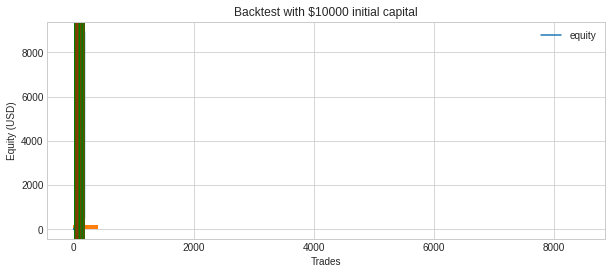

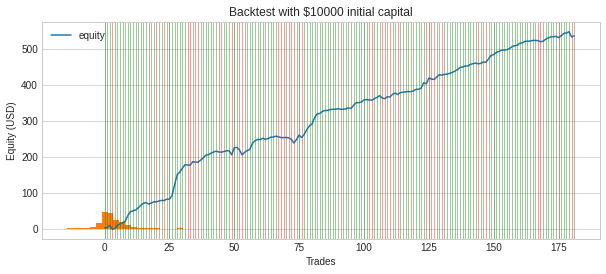

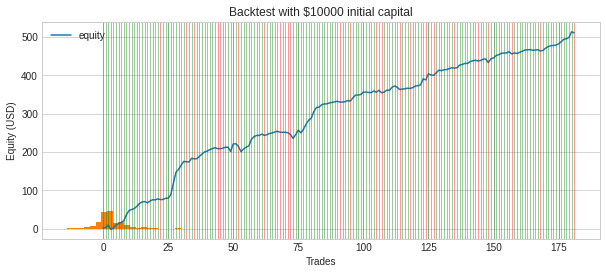

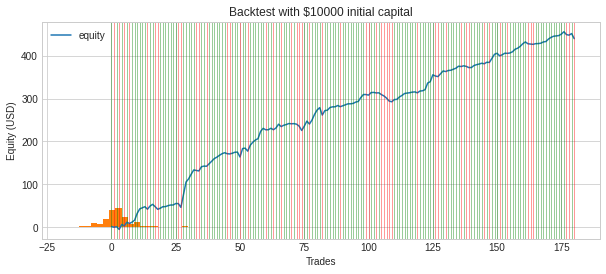

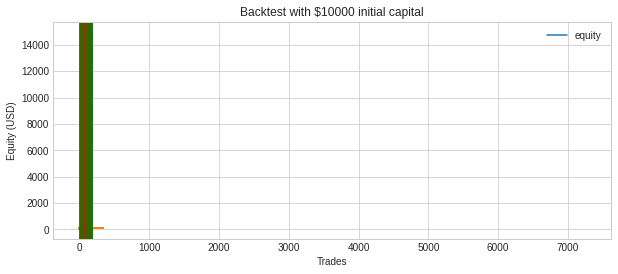

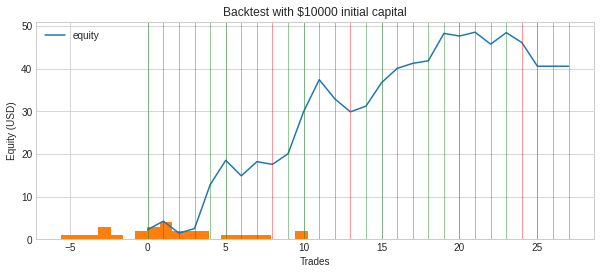

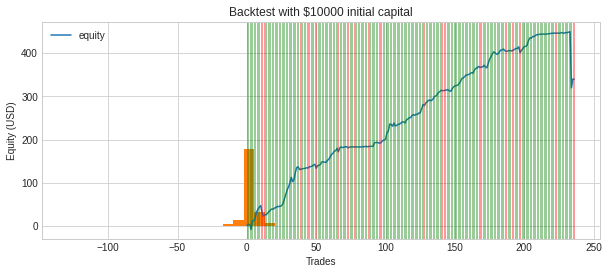

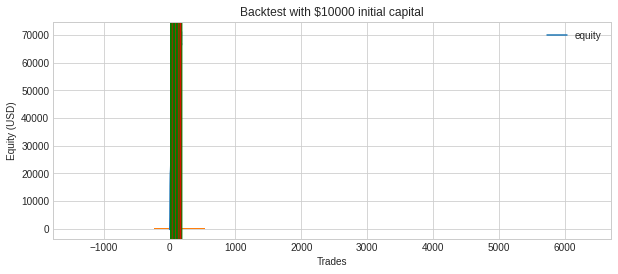

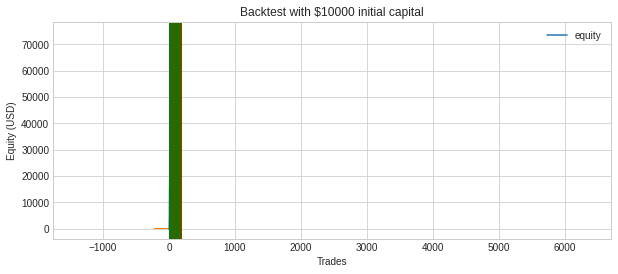

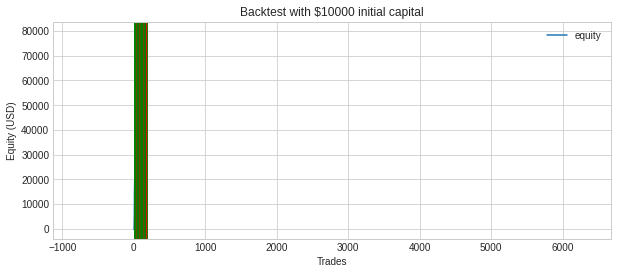

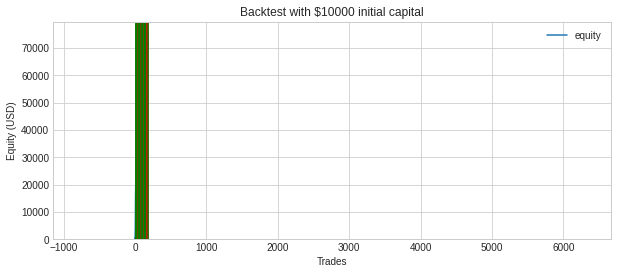

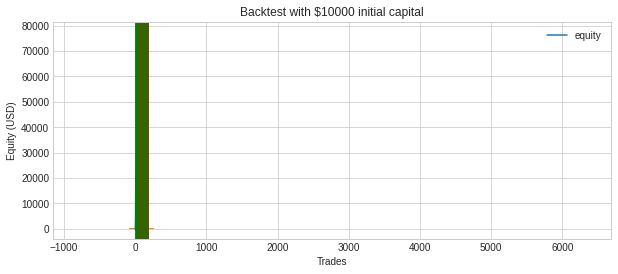

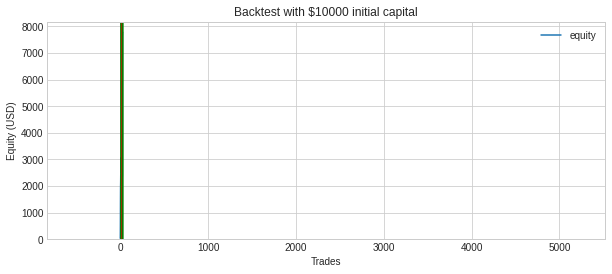

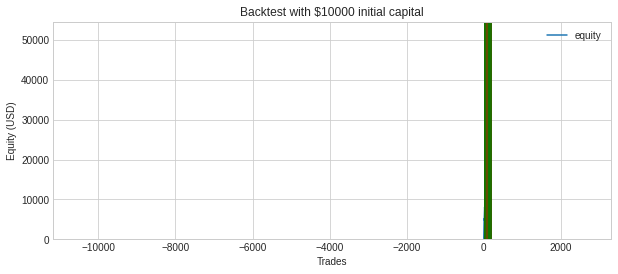

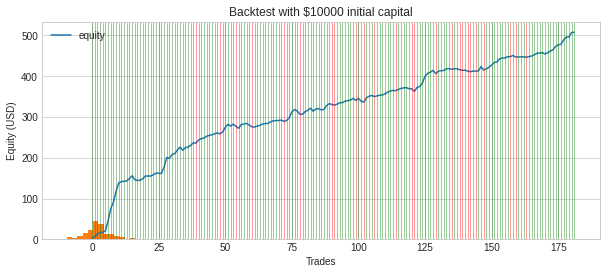

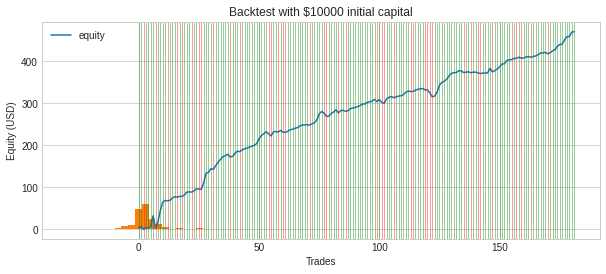

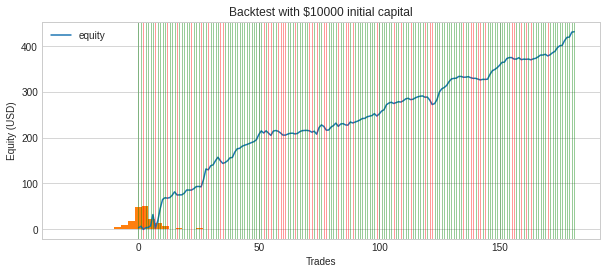

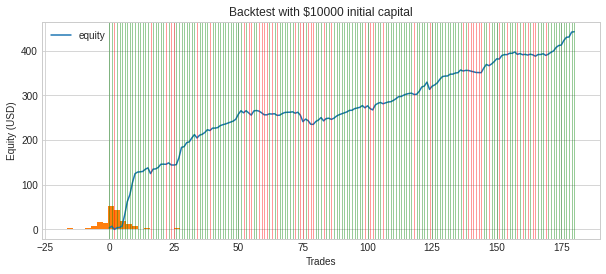

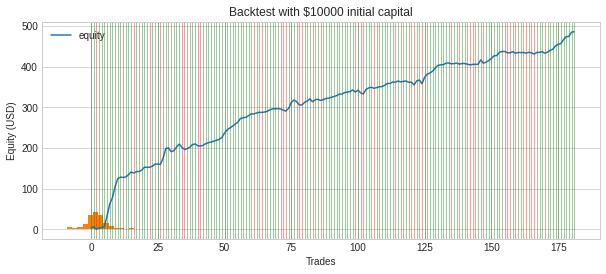

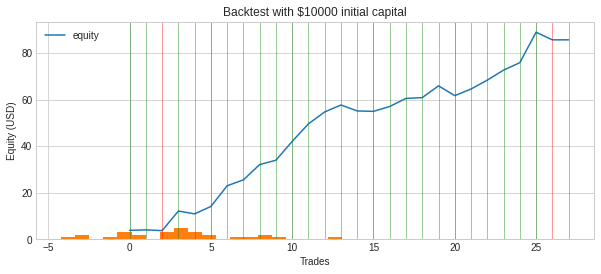

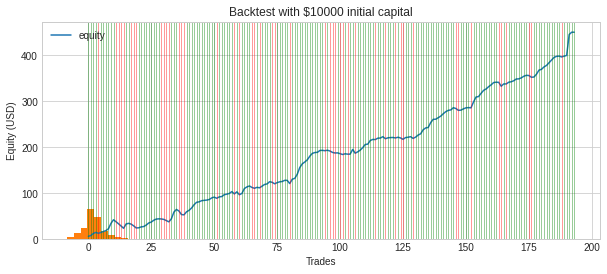

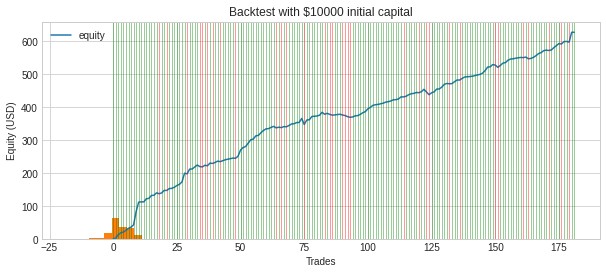

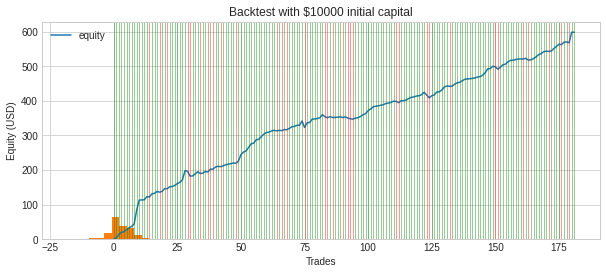

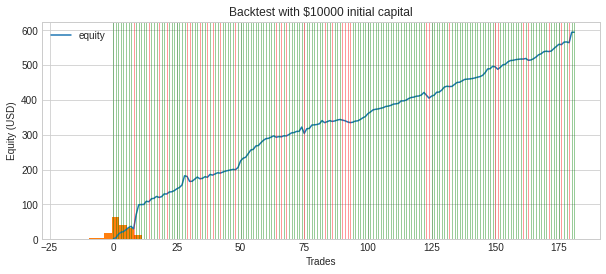

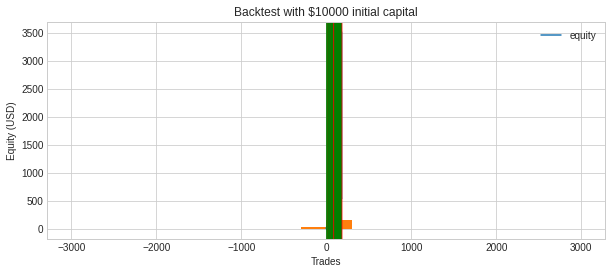

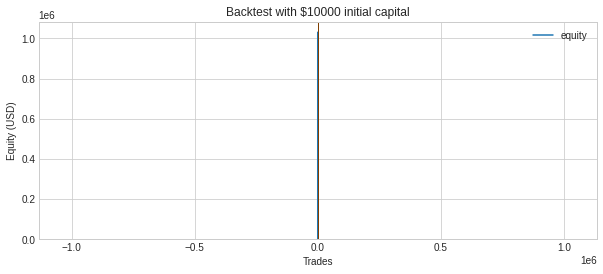

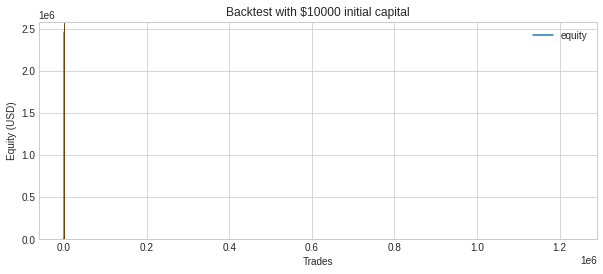

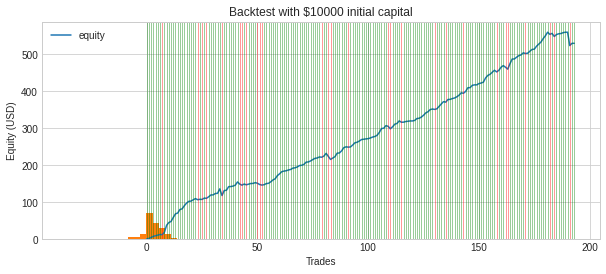

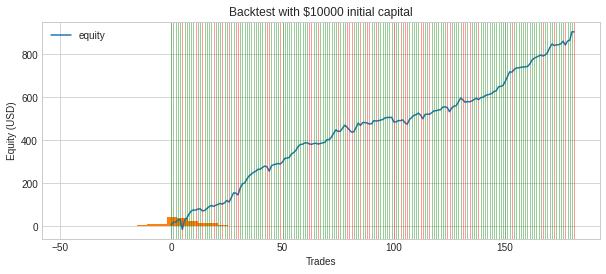

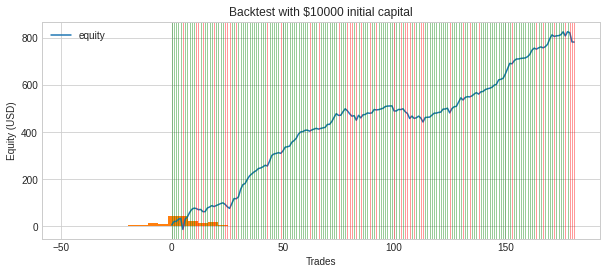

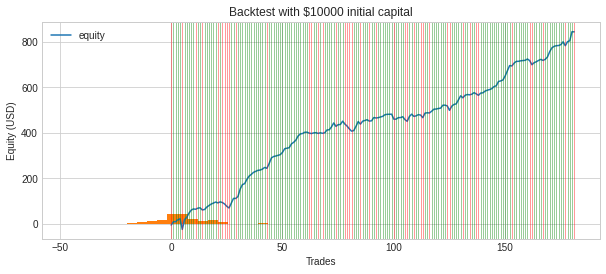

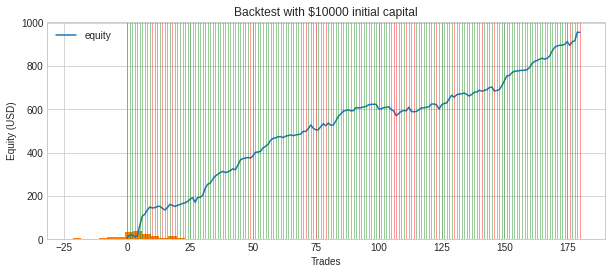

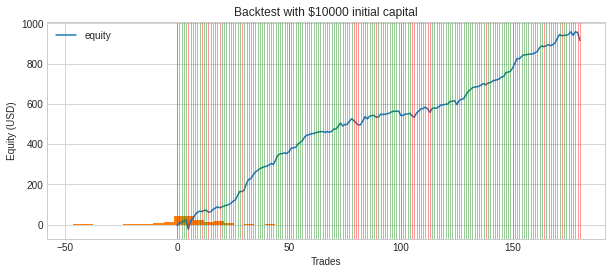

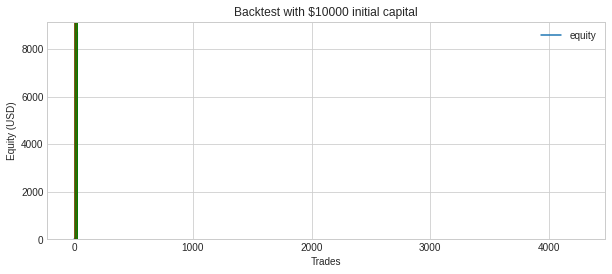

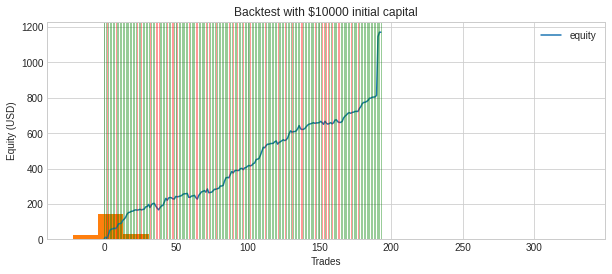

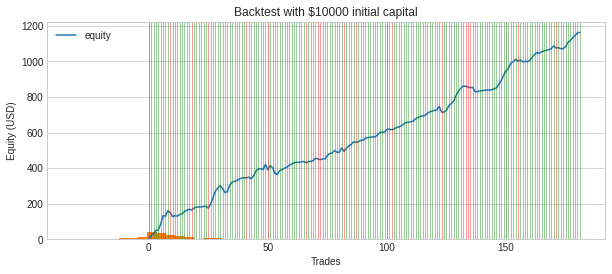

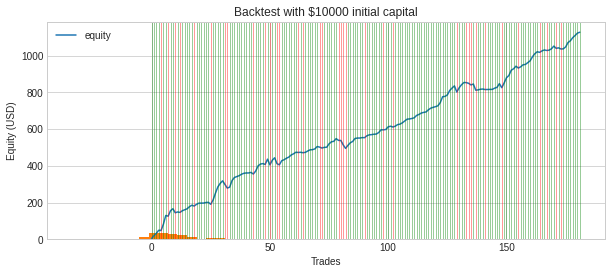

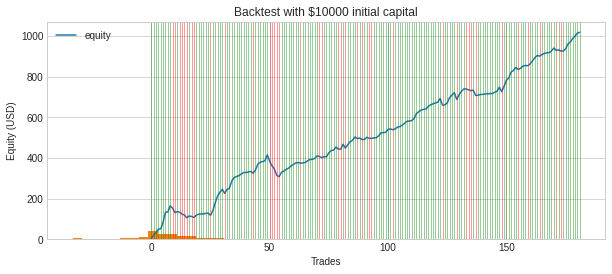

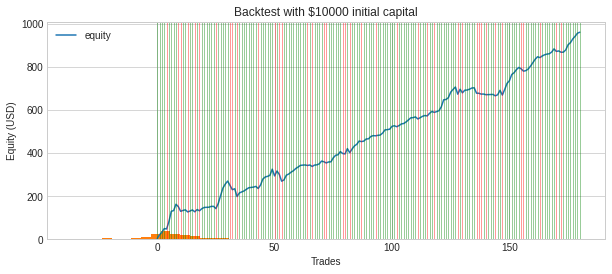

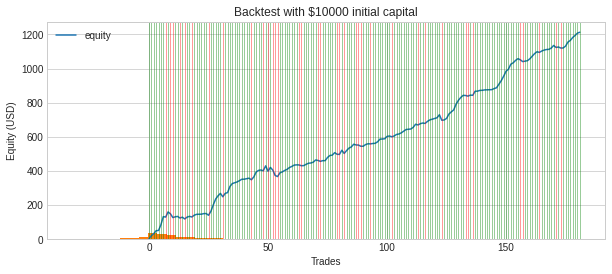

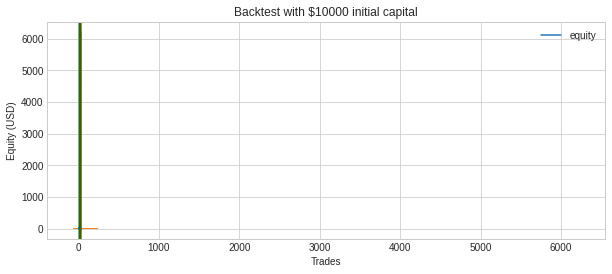

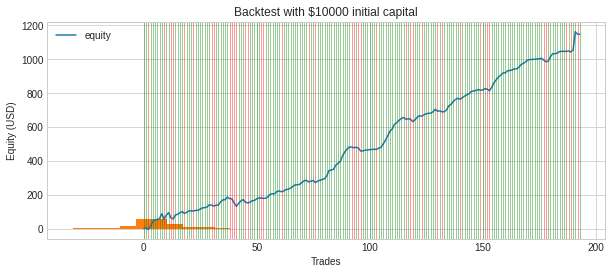

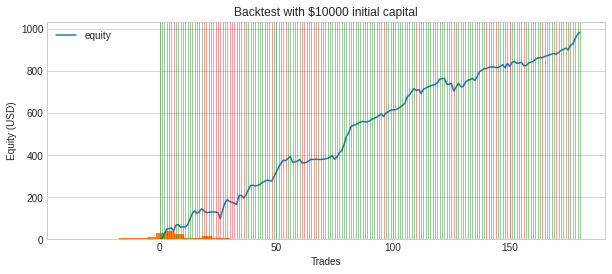

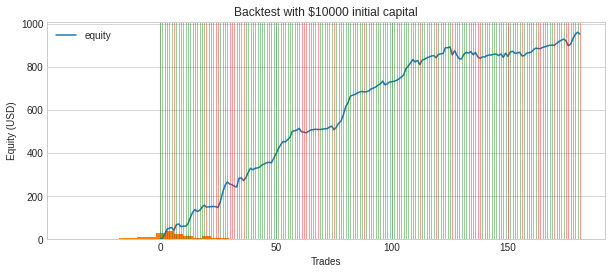

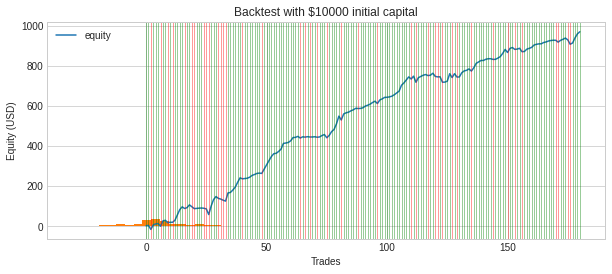

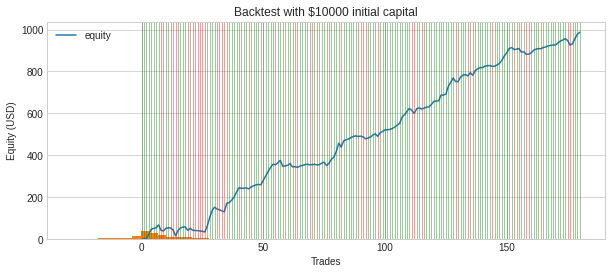

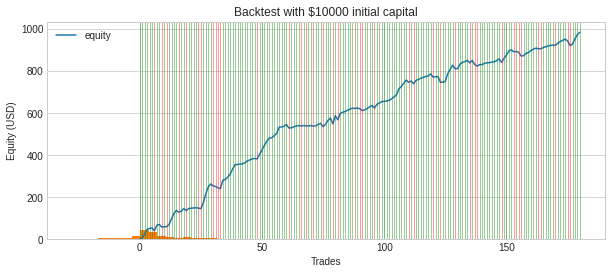

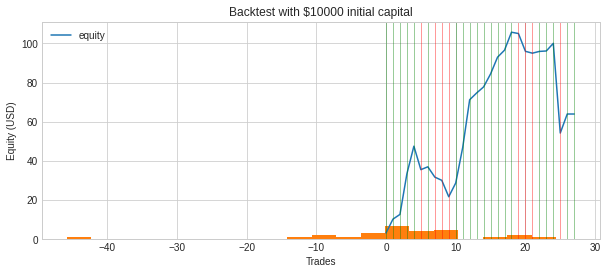

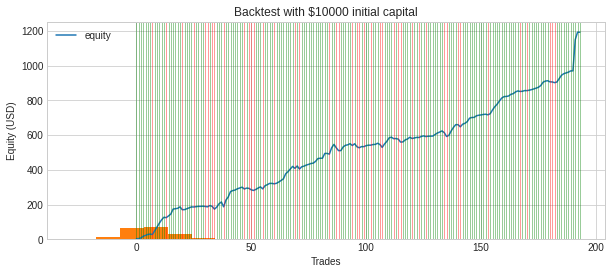

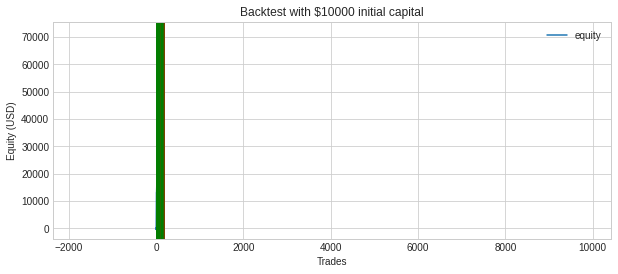

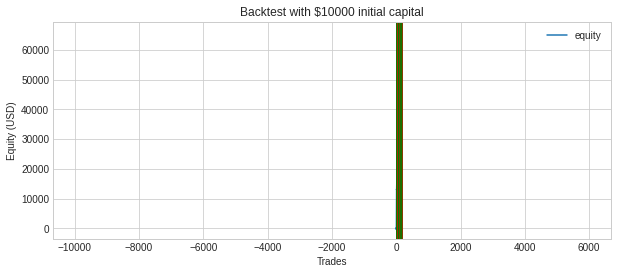

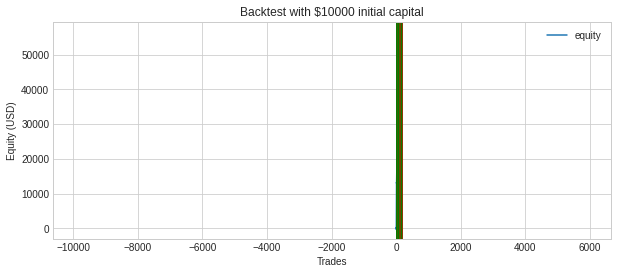

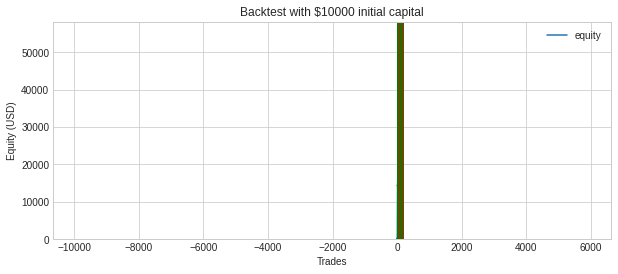

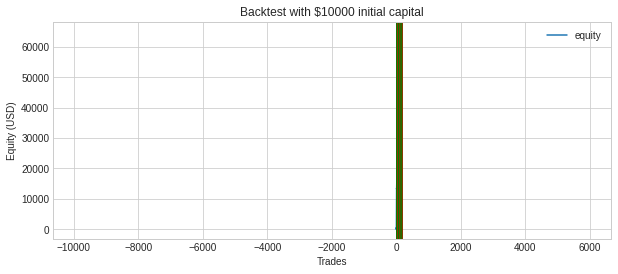

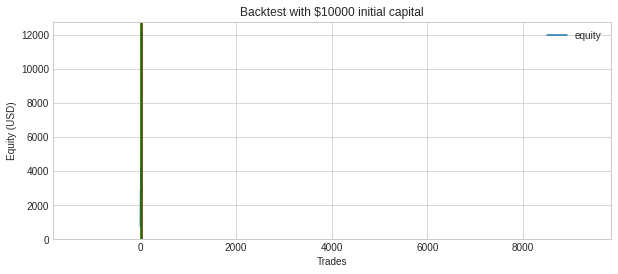

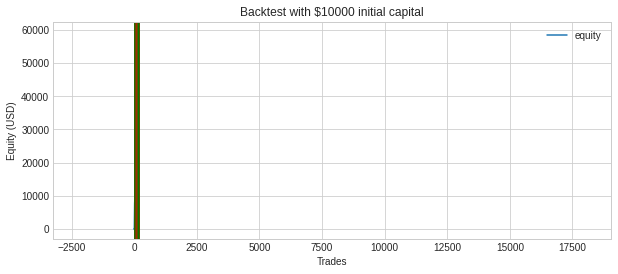

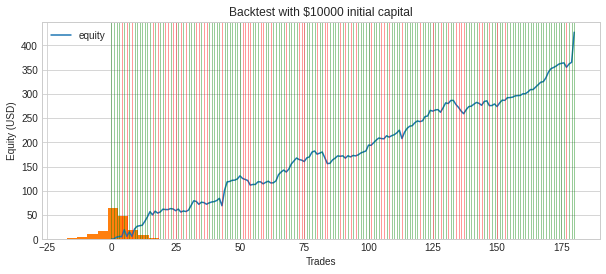

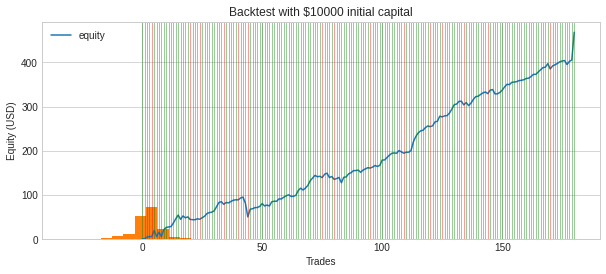

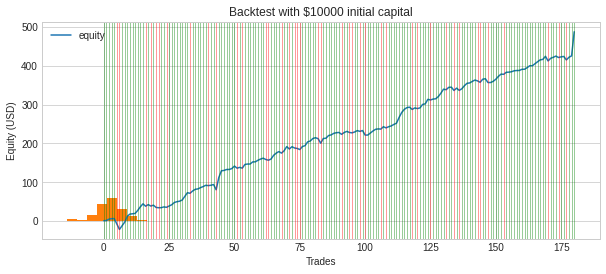

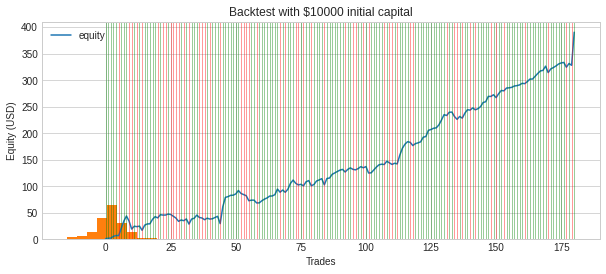

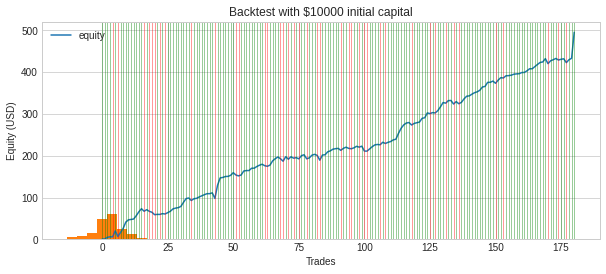

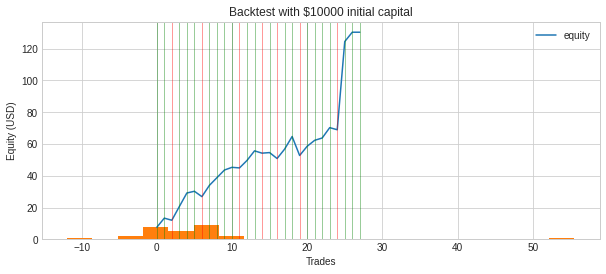

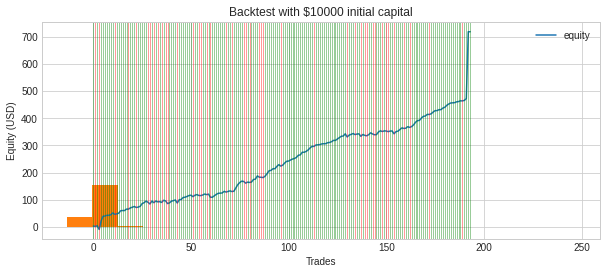

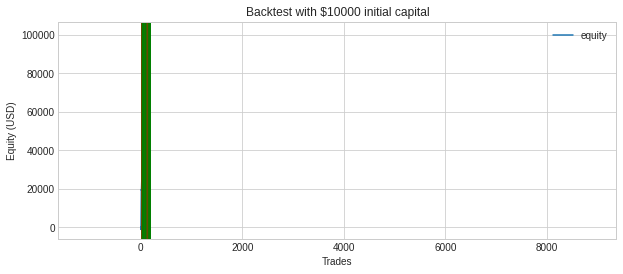

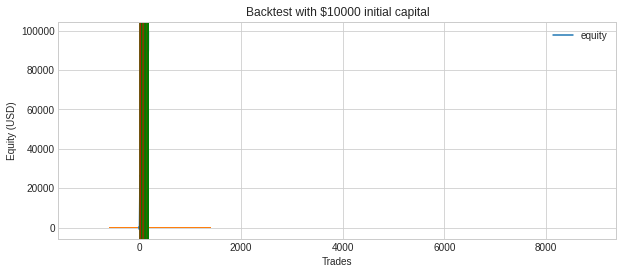

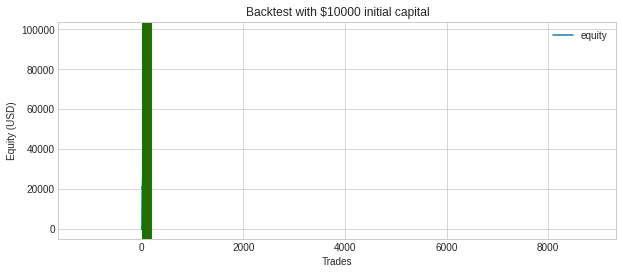

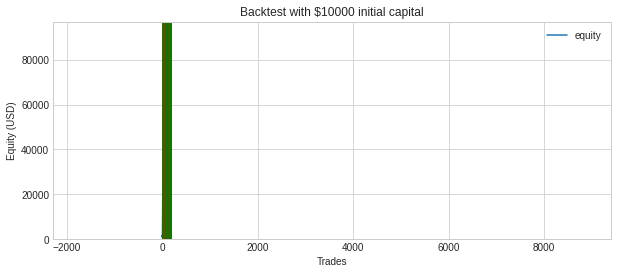

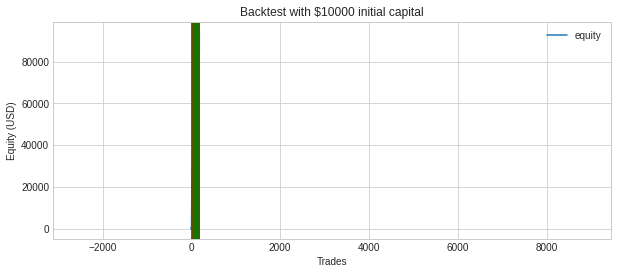

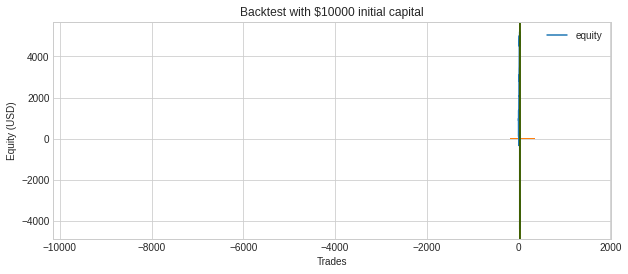

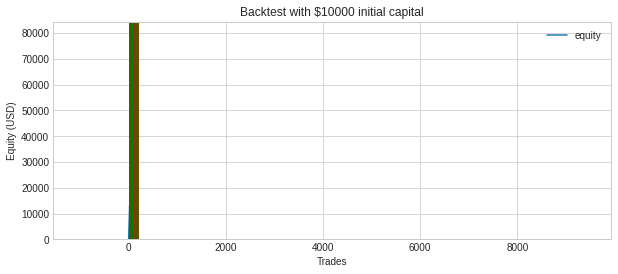

In [9]:
#for all currency pair

EURGBP=df.loc[df['currencyPair'] == "EURGBP"]
USDJPY=df.loc[df['currencyPair'] == "USDJPY"]
USDCHF=df.loc[df['currencyPair'] == "USDCHF"]
EURUSD=df.loc[df['currencyPair'] == "EURUSD"]
EURAUD=df.loc[df['currencyPair'] == "EURAUD"]
GBPAUD=df.loc[df['currencyPair'] == "GBPAUD"]
GBPCAD=df.loc[df['currencyPair'] == "GBPCAD"]
NZDJPY=df.loc[df['currencyPair'] == "NZDJPY"]
NZDUSD=df.loc[df['currencyPair'] == "NZDUSD"]
EURJPY=df.loc[df['currencyPair'] == "EURJPY"]
performPred(EURGBP)
performPred(USDJPY)
performPred(USDCHF)
performPred(EURUSD)
performPred(EURAUD)
performPred(GBPAUD)
performPred(GBPCAD)
performPred(NZDJPY)
performPred(NZDUSD)
performPred(EURJPY)